In [1]:
"""
Simple Diffusion Model using Keras 3 with PyTorch backend
Set KERAS_BACKEND=pytorch before running!
"""
import os
os.environ["KERAS_BACKEND"] = "torch"  # Must be set before importing keras

import keras
from keras import layers, models, ops
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

print(f"Using Keras {keras.__version__} with {keras.backend.backend()} backend\n")

# Set random seed
np.random.seed(42)


Using Keras 3.12.1 with torch backend



In [6]:
def build_noise_predictor(input_dim=2, hidden_dim=128, time_dim=16):
    """Simple MLP for predicting noise"""
    # Input for data
    x_input = layers.Input(shape=(input_dim,), name='x_input')
    # Input for timestep
    t_input = layers.Input(shape=(1,), name='t_input')
    
    # Time embedding
    t_emb = layers.Dense(time_dim, activation='relu')(t_input)
    #t_emb = layers.Dense(time_dim, activation='relu')(t_emb)
    
    # Concatenate data and time embedding
    combined = layers.Concatenate()([x_input, t_emb])
    
    # Main network
    x = layers.Dense(hidden_dim, activation='relu')(combined)
    x = layers.Dense(hidden_dim, activation='relu')(x)
    x = layers.Dense(hidden_dim, activation='relu')(x)
    output = layers.Dense(input_dim)(x)
    
    model = models.Model(inputs=[x_input, t_input], outputs=output, name='noise_predictor')
    return model


class SimpleDiffusion:
    """Handles the diffusion math"""
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        
        # Linear schedule for betas
        self.betas = np.linspace(beta_start, beta_end, num_timesteps, dtype=np.float32)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
    
    def forward_diffusion(self, x0, t):
        """Add noise to data at timestep t"""
        batch_size = x0.shape[0]
        
        # Sample noise using numpy
        noise = np.random.randn(*x0.shape).astype(np.float32)
        
        # Get alpha values for timestep t
        alpha_t = ops.take(self.alphas_cumprod, t)
        alpha_t = ops.reshape(alpha_t, (batch_size, 1))
        
        # Add noise: x_t = sqrt(alpha_t) * x0 + sqrt(1 - alpha_t) * noise
        noisy_x = ops.sqrt(alpha_t) * x0 + ops.sqrt(1 - alpha_t) * noise
        
        return noisy_x, noise
    
    def sample(self, model, n_samples=500):
        """Generate samples using the reverse diffusion process"""
        # Start from pure noise
        x = np.random.randn(n_samples, 2).astype(np.float32)
        
        # Reverse diffusion
        for t in reversed(range(self.num_timesteps)):
            t_batch = np.full((n_samples,), t, dtype=np.int32)
            
            # Predict noise
            t_normalized = (t_batch.astype(np.float32) / self.num_timesteps).reshape(-1, 1)
            
            # Get prediction and immediately convert to numpy
            pred = model.predict([x, t_normalized], verbose=0)
            predicted_noise = np.array(pred).astype(np.float32)
            
            # Get parameters for timestep t
            beta_t = float(self.betas[t])
            alpha_t = float(self.alphas[t])
            alpha_cumprod_t = float(self.alphas_cumprod[t])
            
            # Denoise
            if t > 0:
                noise = np.random.randn(n_samples, 2).astype(np.float32)
            else:
                noise = np.zeros((n_samples, 2), dtype=np.float32)
            
            # x_{t-1} = (1/sqrt(alpha_t)) * (x_t - (beta_t/sqrt(1-alpha_cumprod_t)) * noise) + sigma * z
            coef = beta_t / np.sqrt(1 - alpha_cumprod_t)
            x = (1 / np.sqrt(alpha_t)) * (x - coef * predicted_noise)
            
            if t > 0:
                sigma = np.sqrt(beta_t)
                x = x + sigma * noise
            
            # Ensure x stays float32 numpy
            x = x.astype(np.float32)
        
        return x


def get_swiss_roll_data(n_samples=2000):
    """Generate 2D Swiss roll dataset"""
    data, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
    # Use only x and z coordinates for 2D visualization
    data = data[:, [0, 2]]
    # Normalize
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return data.astype(np.float32)

def visualize_results(model, diffusion, original_data):
    """Visualize the original data and generated samples"""
    # Generate samples
    generated_samples = diffusion.sample(model, n_samples=500)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original data
    ax1.scatter(original_data[:, 0], original_data[:, 1], alpha=0.5, s=10)
    ax1.set_title("Original Swiss Roll Data")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    
    # Generated data
    ax2.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, s=10, c='orange')
    ax2.set_title("Generated Samples")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    
    plt.tight_layout()
    #plt.savefig('diffusion_results_keras3_pytorch.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nVisualization saved to diffusion_results_keras3_pytorch.png")

def train_diffusion_model(model=None, diffusion=None, data=None, epochs=100, batch_size=128):
    """Train the diffusion model"""
    import torch  # Need PyTorch's autograd for Keras 3 + torch backend
    
    # Training loop
    print("Training...")
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        # Shuffle data
        perm = np.random.permutation(data.shape[0])
        data_shuffled = data[perm]
        
        for i in range(0, data.shape[0], batch_size):
            batch = data_shuffled[i:i+batch_size]
            
            # Sample random timesteps
            t = np.random.randint(0, diffusion.num_timesteps, size=(batch.shape[0],))
            
            # Forward diffusion (add noise) - returns numpy arrays
            noisy_x, noise = diffusion.forward_diffusion(batch, t)
            
            # Prepare timestep input
            t_normalized = (t.astype(np.float32) / diffusion.num_timesteps).reshape(-1, 1)
            
            # Convert to numpy if needed (ensure consistency)
            noisy_x = np.array(noisy_x)
            noise = np.array(noise)
            
            # Train on batch - Keras handles gradients automatically
            loss = model.train_on_batch([noisy_x, t_normalized], noise)
            
            epoch_loss += loss
            num_batches += 1
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f}")
            visualize_results(model, diffusion, data)
    
    return model, diffusion, data




Training simple diffusion model (Keras 3 + PyTorch backend)...
This should take 1-2 minutes on CPU.

Training...
Epoch 20/100, Loss: 0.2485


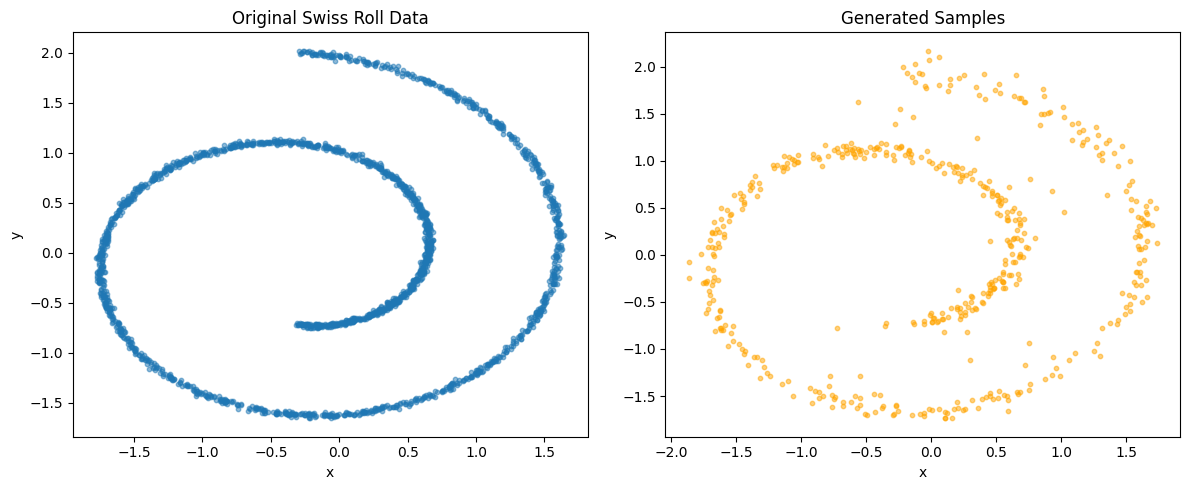


Visualization saved to diffusion_results_keras3_pytorch.png
Epoch 40/100, Loss: 0.2479


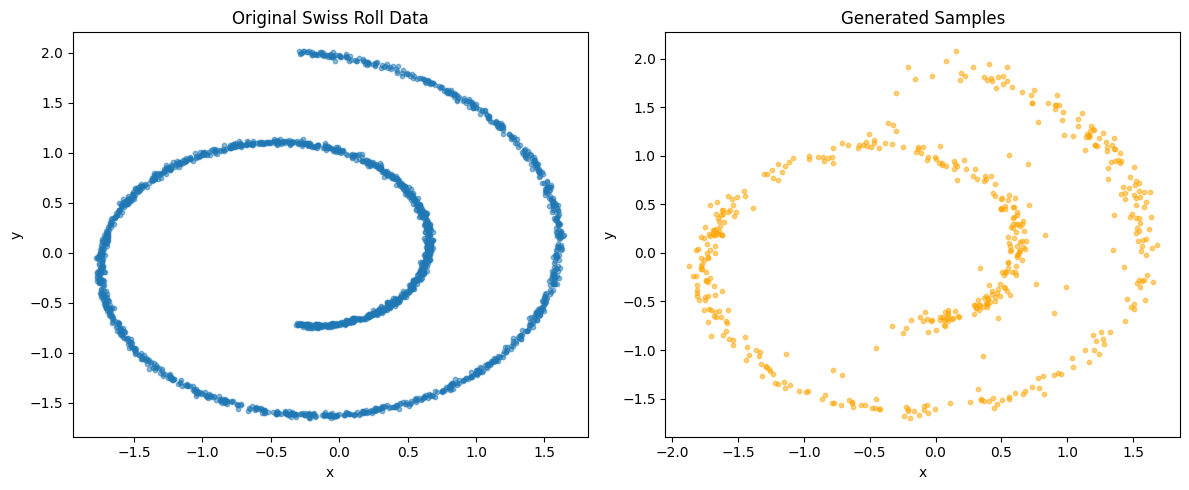


Visualization saved to diffusion_results_keras3_pytorch.png
Epoch 60/100, Loss: 0.2474


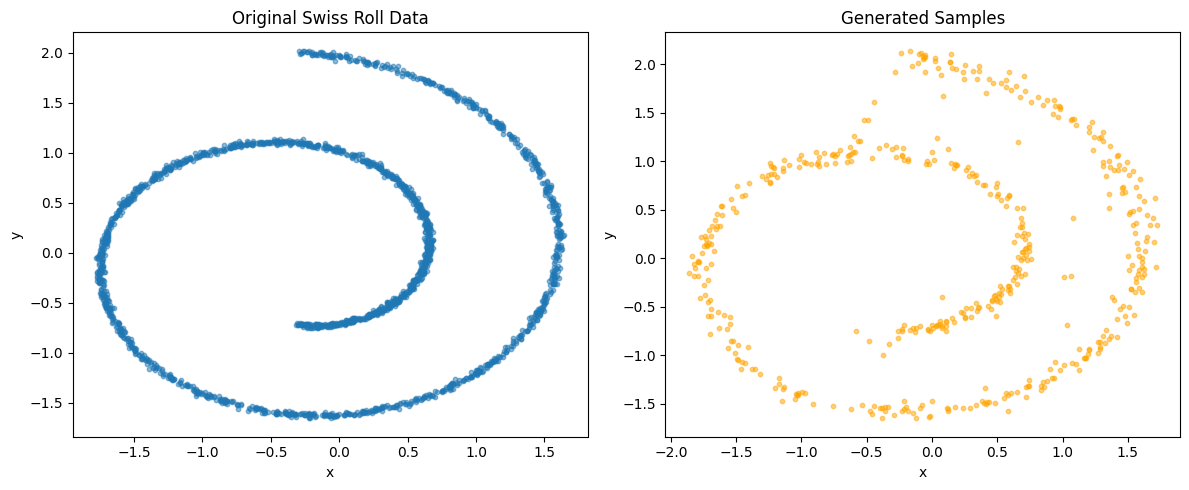


Visualization saved to diffusion_results_keras3_pytorch.png
Epoch 80/100, Loss: 0.2464


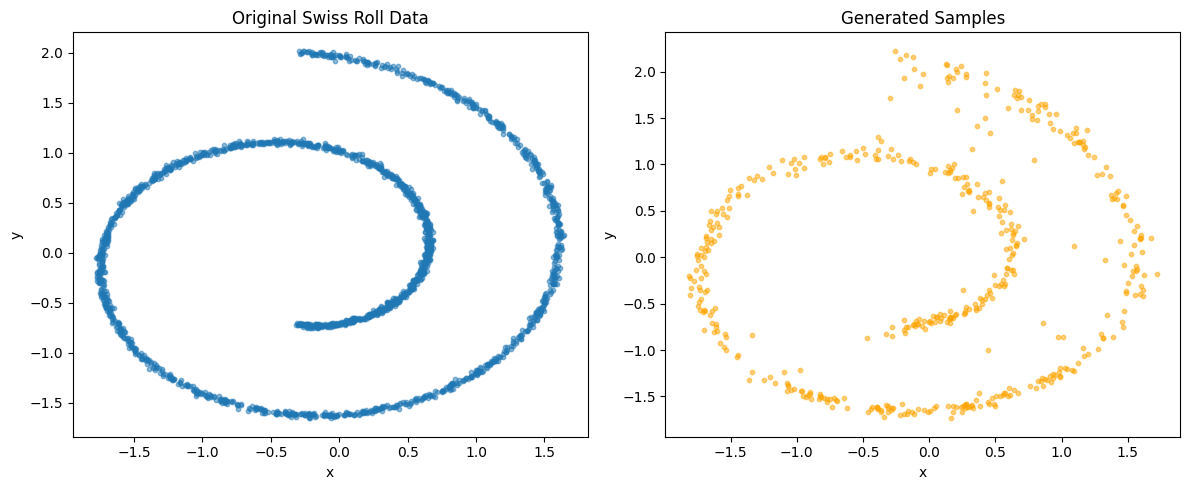


Visualization saved to diffusion_results_keras3_pytorch.png
Epoch 100/100, Loss: 0.2456


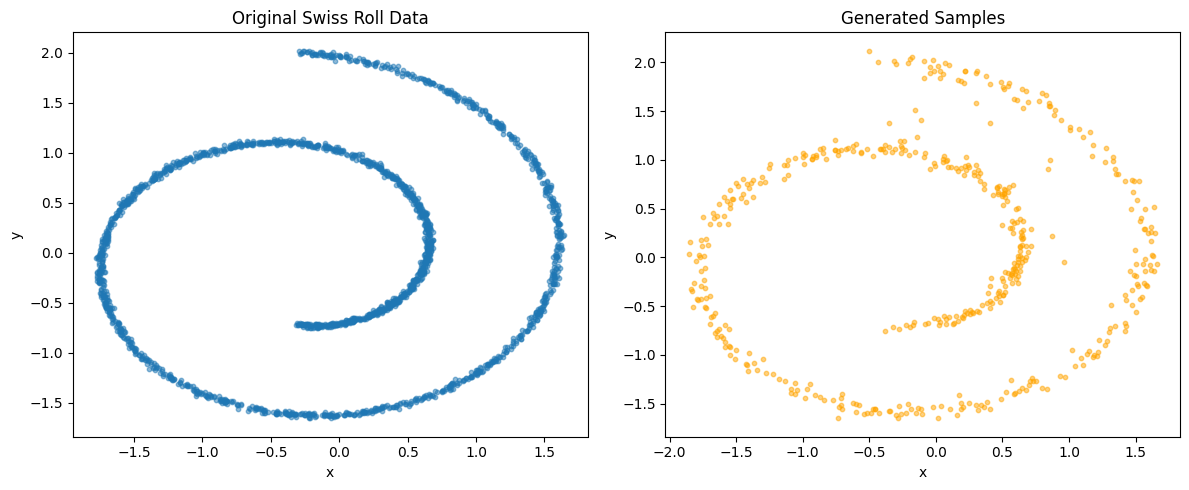


Visualization saved to diffusion_results_keras3_pytorch.png


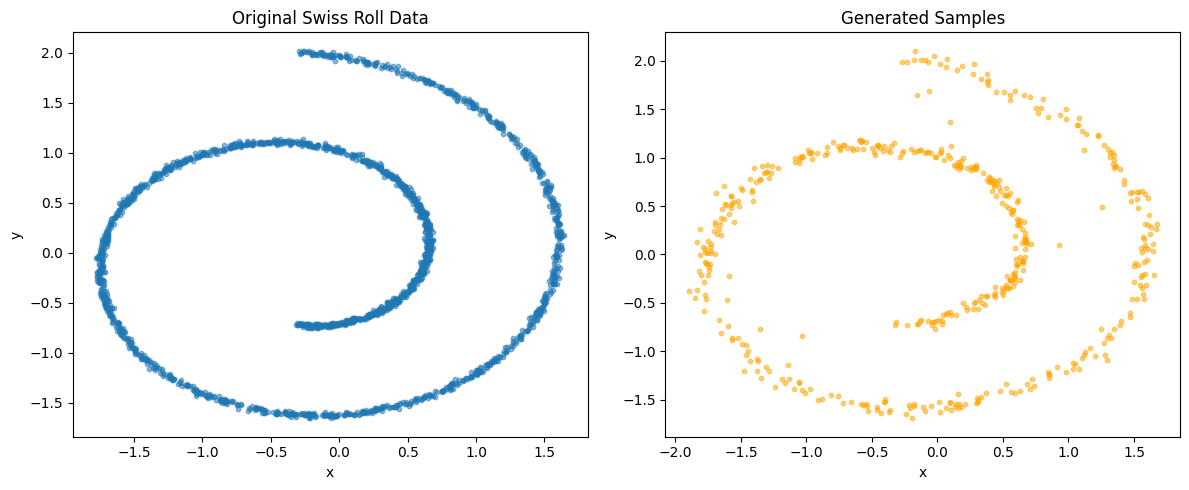


Visualization saved to diffusion_results_keras3_pytorch.png

Done! The model learned to generate Swiss roll data.
Try experimenting with:
  - Different architectures
  - Different noise schedules
  - Different datasets (moons, circles, etc.)


In [11]:

print("Training simple diffusion model (Keras 3 + PyTorch backend)...")
print("This should take 1-2 minutes on CPU.\n")

# Get data
data = get_swiss_roll_data(n_samples=2000)

# Initialize model and diffusion
if False:
    model = build_noise_predictor()
    diffusion = SimpleDiffusion(num_timesteps=1000)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse'  # Mean squared error for predicting noise
    )

# Train model
train_diffusion_model(model=model, data=data, diffusion=diffusion, epochs=100, batch_size=128)

# Visualize
visualize_results(model, diffusion, data)

print("\nDone! The model learned to generate Swiss roll data.")
print("Try experimenting with:")
print("  - Different architectures")
print("  - Different noise schedules")
print("  - Different datasets (moons, circles, etc.)")
